In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm tensorflow keras bayesian-optimization shap gym stable-baselines3 statsmodels pymc3 optuna

  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached stable_baselines3-2.5.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached pymc3-3.11.6-py3-none-any.whl.metadata (15 kB)
  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached arviz-0.20.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached cachetools-5.5.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached deprecat-2.1.3-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
INFO: pip is looking at multiple versions of pymc3 to determine which version is compa

       Month  Website_Clicks  Ad_Spend  Social_Engagement       CTR  \
2 2020-03-31           64886      7612               9768  0.128848   
3 2020-04-30           16265     28483              12685  0.111042   
4 2020-05-31           47194     22159               6831  0.043038   
5 2020-06-30           54131     49974               9071  0.045850   
6 2020-07-31           70263     45994               7708  0.015661   

   Conversions  Engagement_Ratio  Cost_Per_Click  Ad_Efficiency  Month_Number  \
2         9974          0.150541        0.117313       1.310300             3   
3         8026          0.779895        1.751184       0.281782             4   
4         9401          0.144743        0.469530       0.424252             5   
5         6075          0.167575        0.923205       0.121563             6   
6         6030          0.109702        0.654598       0.131104             7   

   Prev_Month_Clicks  Prev_Month_Conversions  Rolling_Clicks  \
2            10860.0  

/var/folders/bx/kl8315dj6xv_z02055vypwnr0000gn/T/ipykernel_33404/3125941038.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Month': pd.date_range(start='1/1/2020', periods=36, freq='M'),


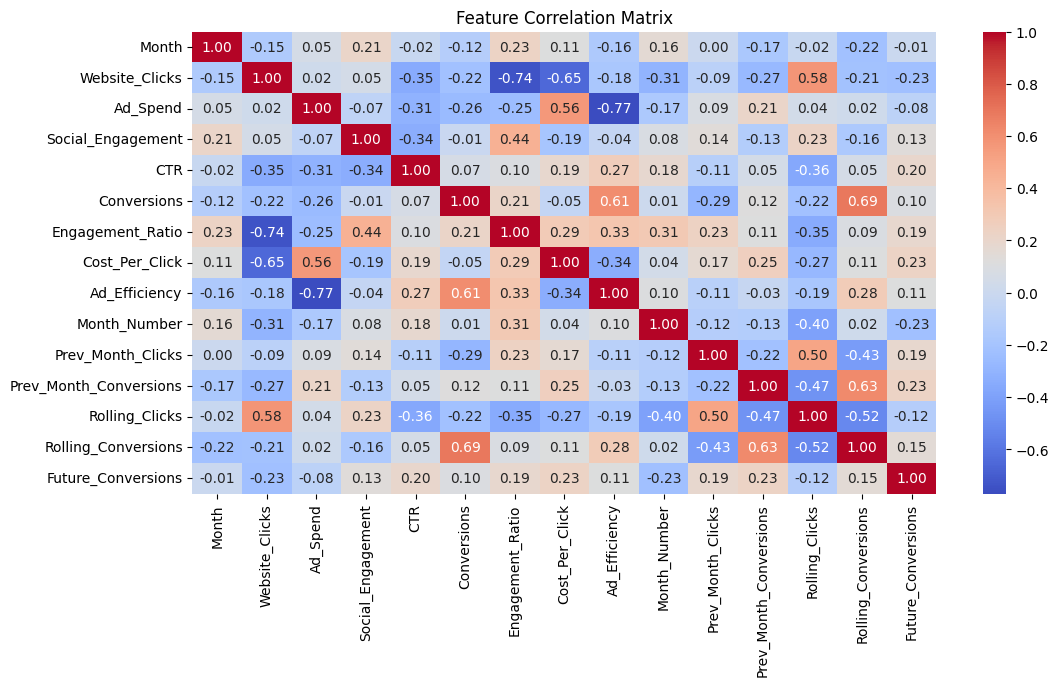

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 5044.115385
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

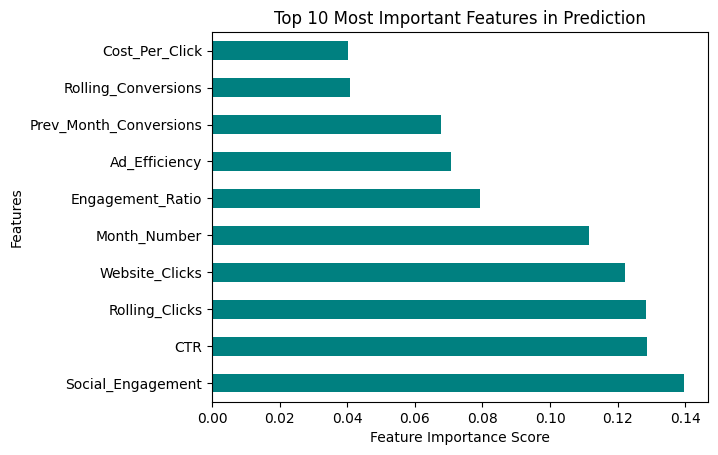

In [9]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Generate Simulated Marketing Data (36 months of data)
np.random.seed(42)
data = {
    'Month': pd.date_range(start='1/1/2020', periods=36, freq='M'),
    'Website_Clicks': np.random.randint(10000, 80000, 36),
    'Ad_Spend': np.random.randint(5000, 50000, 36),
    'Social_Engagement': np.random.randint(500, 20000, 36),
    'CTR': np.random.uniform(0.01, 0.15, 36),  # Click-Through Rate
    'Conversions': np.random.randint(500, 10000, 36)  # Customer Conversions
}

df = pd.DataFrame(data)

# FEATURE ENGINEERING
df['Engagement_Ratio'] = df['Social_Engagement'] / df['Website_Clicks']
df['Cost_Per_Click'] = df['Ad_Spend'] / df['Website_Clicks']
df['Ad_Efficiency'] = df['Conversions'] / df['Ad_Spend']

# SEASONALITY FEATURE: Extracting Month Information
df['Month_Number'] = df['Month'].dt.month

# LAGGED FEATURES (Time Series Analysis)
df['Prev_Month_Clicks'] = df['Website_Clicks'].shift(1)
df['Prev_Month_Conversions'] = df['Conversions'].shift(1)

# MOVING AVERAGE FEATURES
df['Rolling_Clicks'] = df['Website_Clicks'].rolling(window=3).mean()
df['Rolling_Conversions'] = df['Conversions'].rolling(window=3).mean()

df.dropna(inplace=True)  # Drop NaN values from lagged/moving average features

# TARGET VARIABLE - Future Conversions (Predicting Next Month's Conversions)
df['Future_Conversions'] = df['Conversions'].shift(-1)
df.dropna(inplace=True)

# Display Sample Data
print(df.head())

# DATA VISUALIZATION
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# PREPARE DATA FOR MACHINE LEARNING
X = df[['Website_Clicks', 'Ad_Spend', 'Social_Engagement', 'CTR', 'Engagement_Ratio', 
        'Cost_Per_Click', 'Ad_Efficiency', 'Month_Number', 'Prev_Month_Clicks', 
        'Prev_Month_Conversions', 'Rolling_Clicks', 'Rolling_Conversions']]
y = df['Future_Conversions']

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL TRAINING AND COMPARISON
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"MAE": mae, "R² Score": r2}

# DISPLAY RESULTS
results_df = pd.DataFrame(results).T
print("\nMODEL PERFORMANCE COMPARISON:")
print(results_df)

# HYPERPARAMETER TUNING FOR BEST MODEL (Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# FINAL MODEL PERFORMANCE
final_mae = mean_absolute_error(y_test, y_pred_best)
final_r2 = r2_score(y_test, y_pred_best)

print("\nBEST MODEL AFTER TUNING:")
print(f"Final MAE: {final_mae:.2f}")
print(f"Final R² Score: {final_r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

# VISUALIZING FEATURE IMPORTANCE
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Most Important Features in Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

# SAVING PROCESSED DATA FOR TABLEAU / POWER BI
df.to_csv("complex_marketing_analysis.csv", index=False)